In [146]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import dijkstra
from scipy.sparse.linalg import norm, eigen

from matplotlib import pyplot as plt
import networkx as nx

from tqdm.auto import tqdm
from scipy.stats import kendalltau, spearmanr

from load_data import *

In [133]:
# Barcelona
path_net = Path('networks/transport_networks/Barcelona/Barcelona_net.tntp')
path_trips = Path('networks/transport_networks/Barcelona/Barcelona_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Barcelona/Barcelona_net.tntp')

# Winnipeg
path_net = Path('networks/transport_networks/Winnipeg/Winnipeg_net.tntp')
path_trips = Path('networks/transport_networks/Winnipeg/Winnipeg_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Winnipeg/Winnipeg_net.tntp')

# Eastern-Massachusetts
path_net = Path('networks/transport_networks/Eastern-Massachusetts/EMA_net.tntp')
path_trips = Path('networks/transport_networks/Eastern-Massachusetts/EMA_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Eastern-Massachusetts/EMA_net.tntp')

# Anaheim
path_net = Path('networks/transport_networks/Anaheim/Anaheim_net.tntp')
path_trips = Path('networks/transport_networks/Anaheim/Anaheim_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Anaheim/Anaheim_net.tntp')


# Berlin-Mitte-Center
path_net = Path('networks/transport_networks/Berlin-Mitte-Center/berlin-mitte-center_net.tntp')
path_trips = Path('networks/transport_networks/Berlin-Mitte-Center/berlin-mitte-center_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Berlin-Mitte-Center/berlin-mitte-center_net.tntp')


# Berlin-Friedrichshain
path_net = Path('networks/transport_networks/Berlin-Friedrichshain/friedrichshain-center_net.tntp')
path_trips = Path('networks/transport_networks/Berlin-Friedrichshain/friedrichshain-center_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Berlin-Friedrichshain/friedrichshain-center_net.tntp')

# Berlin-Prenzlauerberg-Center
path_net = Path('networks/transport_networks/Berlin-Prenzlauerberg-Center/berlin-prenzlauerberg-center_net.tntp')
path_trips = Path('networks/transport_networks/Berlin-Prenzlauerberg-Center/berlin-prenzlauerberg-center_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Berlin-Prenzlauerberg-Center/berlin-prenzlauerberg-center_net.tntp')

# Berlin-Tiergarten
path_net = Path('networks/transport_networks/Berlin-Tiergarten/berlin-tiergarten_net.tntp')
path_trips = Path('networks/transport_networks/Berlin-Tiergarten/berlin-tiergarten_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Berlin-Tiergarten/berlin-tiergarten_net.tntp')

# Hessen
# path_net = Path('networks/transport_networks/Hessen-Asymmetric/Hessen-Asym_net.tntp')
# path_trips = Path('networks/transport_networks/Hessen-Asymmetric/Hessen-Asym_trips.tntp')
# metadata = read_metadata_networks_tntp('networks/transport_networks/Hessen-Asymmetric/Hessen-Asym_net.tntp')

# Terassa
path_net = Path('networks/transport_networks/Terrassa-Asymmetric/Terrassa-Asym_net.tntp')
path_trips = Path('networks/transport_networks/Terrassa-Asymmetric/Terrassa-Asym_trips.tntp')
metadata = read_metadata_networks_tntp('networks/transport_networks/Terrassa-Asymmetric/Terrassa-Asym_net.tntp')


In [134]:
graph_raw = read_graph_transport_networks_tntp(path_net)

graph = lil_matrix((len(graph_raw.nodes), len(graph_raw.nodes)))
graph.shape

for s, t in graph_raw.edges:
    graph[int(s), int(t)] = 1.0
    
graph.shape

(1664, 1664)

In [135]:
trc_mat = read_traffic_mat_transport_networks_tntp(path_trips, metadata)
trc_mat /= trc_mat.max()

D = []
for s, t in zip(*trc_mat.nonzero()):
    D.append([s, t, trc_mat[s, t]])

D[:3]

[[0, 1610, 0.0044442653], [0, 1611, 0.021343429], [0, 1612, 0.10671714]]

In [96]:
# graph = [
# [0, 1, 2, 0],
# [0, 0, 0, 1],
# [0, 0, 0, 3],
# [0, 0, 0, 0]
# ]
# graph = csr_matrix(graph)
# print(graph)
# dijkstra(csgraph=graph, directed=False, indices=None, return_predecessors=True)

## Toy MCFP

In [97]:
# # f_e; upper triangular
# graph = [
# [0, 1, 1, 0],
# [0, 0, 0, 1],
# [0, 0, 0, 1],
# [0, 0, 0, 0]
# ]
# graph = csr_matrix(graph)

# # commodities: from, to, d
# D = [(0, 2, 1)]


In [98]:
def mcfp(graph, D, eta_f=1e-1, eta_g=1e-1, eps=1e-3, seed=0, n_iter=1_000):
    rows, cols = graph.nonzero()
    np.random.seed(seed)
    # initialization
    y = csr_matrix((np.ones(rows.shape), (rows, cols)), shape=graph.shape)
    dist, pred = dijkstra(csgraph=y, directed=True, indices=None, return_predecessors=True)
    budget = 0.0
    for s, t, d in D:
        cur_node = t
        while cur_node != s:
            cur_node = pred[s, cur_node]
        budget += d * dist[s, t]
    assert budget > 1.0
    y *= 1.5 / budget
    
    src_to_ids = {node: i for i, node in enumerate(set([el[0] for el in D]))}
    losses = []
    n_g = 0
    for k in tqdm(range(n_iter), leave=False):
        budget = -1.0
        dist, pred = dijkstra(csgraph=y, directed=True, indices=[node for node in src_to_ids],
                              return_predecessors=True)
        grad = lil_matrix(graph.shape) * 0 # sum d_k grad l_k
        for s, t, d in D:
            cur_node = t
            while cur_node != s:
                grad[pred[src_to_ids[s], cur_node], cur_node] += d
                cur_node = pred[src_to_ids[s], cur_node]
            budget += d * dist[src_to_ids[s], t]
        assert norm(grad) > 0

        if budget < -eps:
            y += eta_g * grad / norm(grad) / np.sqrt(k + 1)
            n_g += 1
        else:
            losses.append((y.multiply(graph)).sum())
            y -= eta_f * graph / norm(graph) / np.sqrt(k + 1)

        # clip
        y.data = np.where(y.data < 0, 0, y.data)
        if len(losses) > 1 and abs(losses[-1] - losses[-2]) < eps:
            break
        if k % 50 == 0 and k > 0:
            print(min(losses))
                
    return min(losses)
    
mcfp(graph, D)

  0%|          | 0/1000 [00:00<?, ?it/s]

1.2845948145421775
1.137696977830202
1.046615989974506
1.0026625363043553


KeyboardInterrupt: 

## Approximation with effective number of neighbours

In [136]:
def enn_approx(graph, gamma):
    W = (graph + graph.T).asfptype()

    e_vals, _ = eigen.eigsh(W, k=W.shape[0] - 1)
    n_w = 1 / (1 - gamma)
    n_w /= np.sum(e_vals ** 2 / (1 - gamma * e_vals ** 2)) / W.shape[0]
    return n_w

enn_approx(graph, 0.001)

0.16932464177162726

## Approximation wth Laplace spectral gap

In [80]:
def spectral_gap_approx(graph):
    W = (graph + graph.T).asfptype()
    Deg = lil_matrix(graph.shape)
    degrees = np.asarray(W.sum(-1)).reshape(-1)
    for i, d in enumerate(degrees):
        Deg[i, i] = d
    L = Deg - W
    e_vals, _ = eigen.eigsh(W, k=2)
    l1, l2 = np.sort(e_vals)[-2:]
    return l2 - l1#, e_vals.max() / e_vals[e_vals > 0].min()

spectral_gap_approx(graph)

0.05362114970053167

In [137]:
results = {
    'Barcelona': {'solution': 0.796, 'enn_1e-2': 0.131, 'enn_1e-3': 0.162, 'spec_gap': 0.971},
    'Winnipeg': {'solution': 0.358, 'enn_1e-2': 0.098, 'enn_1e-3': 0.123, 'spec_gap': 1.347},
    'EMA': {'solution': 0.525, 'enn_1e-2': 0.037, 'enn_1e-3': 0.069, 'spec_gap': 0.4778},
    'Anaheim': {'solution': 0.162, 'enn_1e-2': 0.131, 'enn_1e-3': 0.163, 'spec_gap': 0.542},
    'Berlin-Mitte-Center': {'solution': 0.137, 'enn_1e-2': 0.181, 'enn_1e-3': 0.206, 'spec_gap': 0.332},
    'Berlin-Friedrichshain': {'solution': 0.406, 'enn_1e-2': 0.168, 'enn_1e-3': 0.193, 'spec_gap': 0.079},
    'Berlin-Prenzlauerberg-Center': {'solution': 0.09, 'enn_1e-2': 0.204, 'enn_1e-3': 0.229, 'spec_gap': 0.234},
    'Berlin-Tiergarten': {'solution': 0.411, 'enn_1e-2': 0.189, 'enn_1e-3': 0.212, 'spec_gap': 0.016},
    # 'Hessen': {'solution': 1.115, 'enn': 0, 'spec_gap': 0.227}, # enn is slow
    'Terassa': {'solution': 0.589, 'enn_1e-2': 0.149, 'enn_1e-3': 0.169, 'spec_gap': 0.053},
}

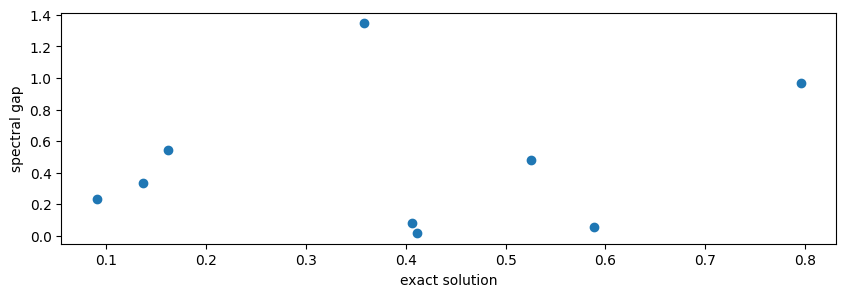

KendalltauResult(correlation=0.0, pvalue=1.0)

In [144]:
plt.figure(figsize=(10, 3))
sol = [r['solution'] for r in results.values()]
spec = [r['spec_gap'] for r in results.values()]
plt.scatter(sol, spec)
plt.xlabel('exact solution')
plt.ylabel('spectral gap')

plt.show()
kendalltau(sol, spec)

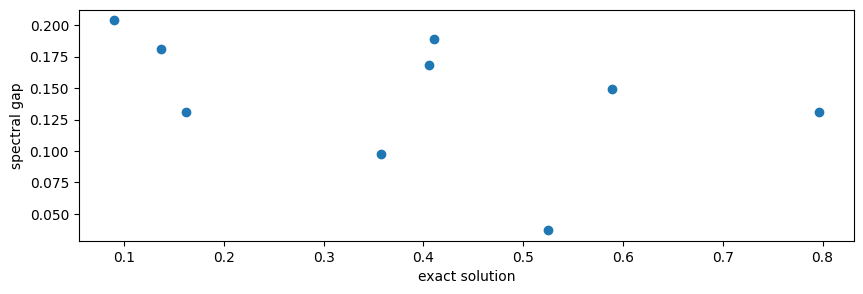

KendalltauResult(correlation=-0.36623351038235713, pvalue=0.17295491798842078)

In [148]:
plt.figure(figsize=(10, 3))
sol = [r['solution'] for r in results.values()]
enn = [r['enn_1e-2'] for r in results.values()]
plt.scatter(sol, enn)
plt.xlabel('exact solution')
plt.ylabel('spectral gap')

plt.show()
kendalltau(sol, enn)

## Experiment with synthetic graphs

In [12]:
g = nx.balanced_tree(2, 2)
g.edges
# nx.draw(g)

EdgeView([(0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (2, 6)])

In [18]:
def gen_graph(r, h, seed=0):
    np.random.seed(seed)
    g = nx.balanced_tree(r, h)
    graph = lil_matrix((len(g.nodes), len(g.nodes)))
    for s, t in g.edges:
        graph[min(s, t), max(s, t)] = 1
    selected_comm = [(0, 1, 1)]
    for i in range(len(g.nodes)):
        for j in range(i + 1, len(g.nodes)):
            if np.random.rand() < 0.1:
                g.add_edge(i, j)
            if np.random.rand() < 0.1 and i != 0 and j != 1:
                selected_comm.append([i, j, 1.0])
    
    # infinite capacity
    return graph * 100, selected_comm

# print(gen_graph(2, 3)[0])

In [19]:
graphs_comm = [gen_graph(r, h, seed=s) for r in [2,3] \
               for h in [2,3] for s in range(10)]

In [20]:
mcfp_sol = [mcfp(graph, D) for graph, D in tqdm(graphs_comm)]


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

234.1523613551024
171.89386629285383
125.52893871896464
99.94009176967906
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90072349572631


  0%|          | 0/1000 [00:00<?, ?it/s]

234.15236135510244
171.89386629285383
125.52893871896464
99.94009176967906
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90238524989951
99.90072349572631


IndexError: index -9999 is out of bounds for axis 1 with size 7

In [27]:
gaps = [spectral_gap_approx(graph) for graph, _ in graphs_comm]
# gaps

KendalltauResult(correlation=0.1482524958667068, pvalue=0.18331347243537044)

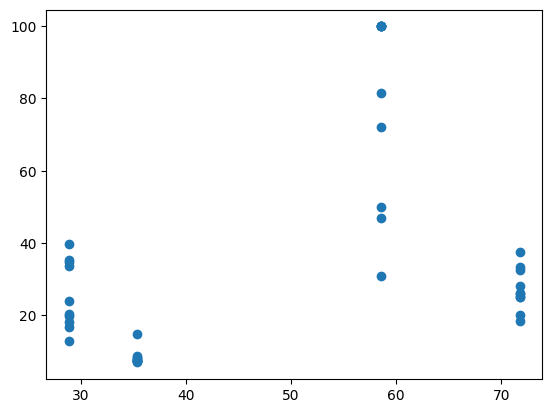

In [28]:
plt.scatter(gaps, mcfp_sol)
kendalltau(gaps, mcfp_sol)

KendalltauResult(correlation=0.1411636340774045, pvalue=0.23618314387241357)

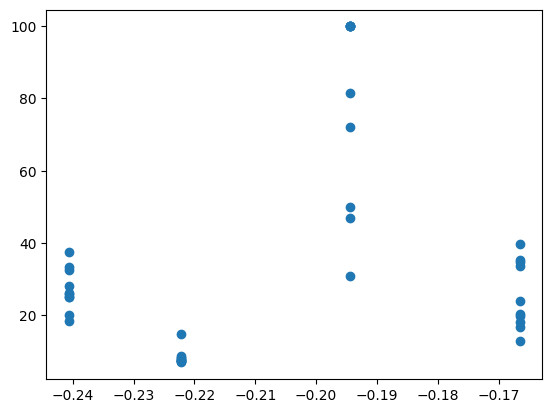

In [29]:
n_eff = [enn_approx(graph, 0.1) for graph, D in graphs_comm]
plt.scatter(n_eff, mcfp_sol)
kendalltau(n_eff, mcfp_sol)

## Conclusion

Spectral gap of the Laplace matrix and effective number of neighbours 
do not correlate with the solution of the MCFP.

__Possible reasons__

1. The proposed metrix do not consider the set of commodities.
2. Additionally, spetral metrics do not consider capacities.



In [183]:
! open .